In [1]:
import numpy as np
import utilities as u

import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

from pathlib import Path

# Surpress warnings related to NaNs
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib widget

In [2]:
model_dir0 = "DataAugmented"
model_dir1 = "SuperResolution"

var = "Hs"

# Define the point where the time series is extracted (in pixel)
xi = [69, 86, 69]
yi = [94, 104, 77] 

# Define length of extraction points for easier acess
n = len(xi)

# Number of boxes
nbox = 12

# Save the figure?
save = False

In [3]:
def get_plotting_data(xi, yi, model_dir, var, npts, nbox, min_max_range):
    """
    Compute the mean error and difference over nbox boxes and return 
    them, plus their standard deviation.
    """
    prediction = []
    HR = []
    LR = []
    HR_train = []

    for j, coords in enumerate(zip(xi, yi)):
        x, y = coords[0], coords[1]


        # Load time series of predictions and training data
        path_dir = Path(f"Data/Time_Series/{model_dir}")
        
        fpath = path_dir / f"Var_{var}_posxy_{x}_{y}.npy"
        fpath_train = path_dir / f"Ref_Var_{var}_posxy_{x}_{y}.npy"

        arr = np.load(fpath)
        arr_train = np.load(fpath_train)

        prediction.append(arr[0, :])
        HR.append(arr[1, :])
        LR.append(arr[2, :])
        HR_train.append(arr_train)
        
    # Compute Error and Difference for all extraction points
    error = []    
    diff = []

    # Loop over all points
    for i in range(npts):
        difference = np.abs(HR[i] - prediction[i])
        diff.append(difference)


    # Get the partition of the variable value with the help of a histogram
    _, edges = np.histogram(prediction[0], nbox, range=min_max_range)
    
    # From edges create an array with the middle position
    mid_pos = ((edges + np.roll(edges, 1))/2)[1:]

    # Create a list that will contain the data for all the boxes
    box_NRMSE = np.empty((npts, nbox))
    box_diff = np.empty((npts, nbox))
    box_diff_std = np.empty((npts, nbox))

    for i in range(npts):
        for j in range(nbox):
            # Extract all data points in one box and compute mean
            condition = ((edges[j] <= prediction[i]) &
                         (prediction[i] < edges[j+1]))
            
            data_diff = diff[i][condition]
            mean = np.nanmean(HR[i][condition])
            box_NRMSE[i, j] = np.sqrt(np.nanmean(data_diff**2))/mean*100
            box_diff[i, j] = np.mean(data_diff)
            box_diff_std[i, j] = np.std(data_diff)
            
            
    return box_NRMSE, box_diff, box_diff_std, mid_pos, HR_train

In [4]:
def add_data_augmented(HR_train: np.ndarray, xi, yi):
    new_HR_train = []
    for i, HR in enumerate(HR_train):
        # Load data augmented data and add it to original time series
        aug = np.load(f"Data/AugmentedData_Time_Series/Point_{xi[i]}_{yi[i]}.npy") 
        new_HR_train.append(np.r_[HR, aug])
        
    return new_HR_train

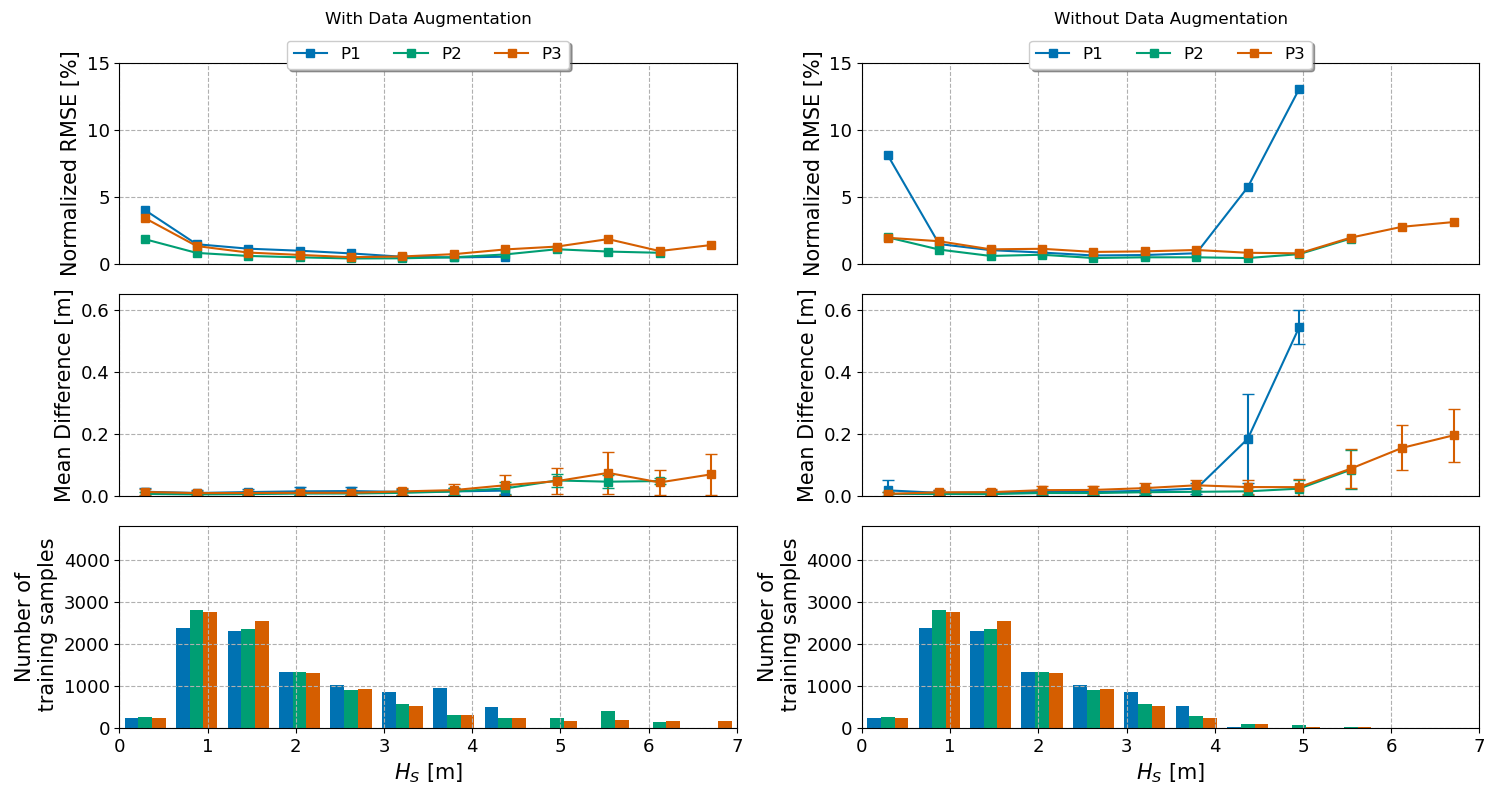

In [5]:
LABELSIZE = 15
TICKLABELSIZE = 13
LEGENDFONTSIZE = 12
# y-scale for histograms
YMAX = 4800

fig, axs = plt.subplots(3, 2, figsize=(15,8))

label = ["P1", "P2", "P3"]
xlabel = {0: r"$H_S$ ", 1: r"$T_{m02}$ ", 2: r"Dir "}
units = {0: "[m]", 1: "[s]", 2: "[°]"}
  
min_max_range = (0, 7)
nrmse_range = (0, 15.0)
diff_range = (0, 0.65)


# First plot, with data augmentation

box_NRMSE, box_diff, box_diff_std, mid_pos, HR_train = get_plotting_data(
                  xi, yi, model_dir0, var, n, nbox, min_max_range
)

# Add extra data to ref_training
HR_train = add_data_augmented(HR_train, xi, yi)

axs[0,0].plot(mid_pos, box_NRMSE.T, label=label, marker='s')
# axs[1,0].plot(mid_pos, box_diff.T, label=label, marker='s')
axs[1,0].errorbar(mid_pos, box_diff[0,:], yerr=box_diff_std[0,:], label=label, marker='s', capsize=4)
axs[1,0].errorbar(mid_pos, box_diff[1,:], yerr=box_diff_std[1,:], label=label, marker='s', capsize=4)
axs[1,0].errorbar(mid_pos, box_diff[2,:], yerr=box_diff_std[2,:], label=label, marker='s', capsize=4)
axs[2,0].hist(HR_train, nbox, label=label, range=min_max_range)

axs[0,0].set_title("With Data Augmentation", y=1.15)
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          fancybox=True, shadow=True, ncol=3, fontsize=LEGENDFONTSIZE)
axs[0,0].grid(True, axis="both", ls="--")
axs[0,0].set_xlim(*min_max_range)
axs[0,0].set_ylim(*nrmse_range)
axs[0,0].set_ylabel("Normalized RMSE [%]", size=LABELSIZE)
axs[0,0].tick_params(axis='both', left=True, top=False, right=False, bottom=False,
                     labelleft=True, labeltop=False, labelright=False, labelbottom=False,
                     labelsize=TICKLABELSIZE)

axs[1,0].grid(True, axis="both", ls="--")
axs[1,0].set_xlim(*min_max_range)
axs[1,0].set_ylim(*diff_range)
axs[1,0].set_ylabel("Mean Difference " + units[0], size=LABELSIZE)
axs[1,0].tick_params(axis='both', left=True, top=False, right=False, bottom=False,
                     labelleft=True, labeltop=False, labelright=False, labelbottom=False,
                     labelsize=TICKLABELSIZE)

axs[2,0].grid(True, axis="both", ls="--")
axs[2,0].set_xlim(*min_max_range)
axs[2,0].set_ylim(0, YMAX)
axs[2,0].set_ylabel("Number of\n training samples", size=LABELSIZE)
axs[2,0].set_xlabel(xlabel[0] + units[0], size=LABELSIZE)
axs[2,0].tick_params(axis='both', labelsize=TICKLABELSIZE)
    


# Second plot, without data augmentation
box_NRMSE, box_diff, box_diff_std, mid_pos, HR_train = get_plotting_data(
                  xi, yi, model_dir1, var, n, nbox, min_max_range
)
    
axs[0,1].plot(mid_pos, box_NRMSE.T, label=label, marker='s')
axs[1,1].errorbar(mid_pos, box_diff[0,:], yerr=box_diff_std[0,:], label=label, marker='s', capsize=4)
axs[1,1].errorbar(mid_pos, box_diff[1,:], yerr=box_diff_std[1,:], label=label, marker='s', capsize=4)
axs[1,1].errorbar(mid_pos, box_diff[2,:], yerr=box_diff_std[2,:], label=label, marker='s', capsize=4)
axs[2,1].hist(HR_train, nbox, label=label, range=min_max_range)


axs[0,1].set_title("Without Data Augmentation", y=1.15)
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          fancybox=True, shadow=True, ncol=3, fontsize=LEGENDFONTSIZE)
axs[0,1].grid(True, axis="both", ls="--")
axs[0,1].set_xlim(*min_max_range)
axs[0,1].set_ylim(*nrmse_range)
axs[0,1].set_ylabel("Normalized RMSE [%]", size=LABELSIZE)
axs[0,1].tick_params(axis='both', left=True, top=False, right=False, bottom=False,
                     labelleft=True, labeltop=False, labelright=False, labelbottom=False,
                     labelsize=TICKLABELSIZE)

axs[1,1].grid(True, axis="both", ls="--")
axs[1,1].set_xlim(*min_max_range)
axs[1,1].set_ylim(*diff_range)
axs[1,1].set_ylabel("Mean Difference " + units[0], size=LABELSIZE)
axs[1,1].tick_params(axis='both', left=True, top=False, right=False, bottom=False,
                     labelleft=True, labeltop=False, labelright=False, labelbottom=False,
                     labelsize=TICKLABELSIZE)

axs[2,1].grid(True, axis="both", ls="--")
axs[2,1].set_xlim(*min_max_range)
axs[2,1].set_ylim(0, YMAX)
axs[2,1].set_ylabel("Number of\n training samples", size=LABELSIZE)
axs[2,1].set_xlabel(xlabel[0] + units[0], size=LABELSIZE)
axs[2,1].tick_params(axis='both', labelsize=TICKLABELSIZE)
    

fdir = Path("Plots")
fname = f"ErrMeanStdAndDiff_Augmented_{xi}_{yi}_mdir{model_dir1}.png"

plt.tight_layout()
plt.subplots_adjust(hspace=0.15)

if save:
    if not fdir.exists():
        fdir.mkdir()
    plt.savefig(fdir / fname)

plt.show()